In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
featuresPath = 'transcripts_features.csv'

In [4]:
features = pd.read_csv(featuresPath)

In [5]:
features.head()

,Unnamed: 0,voice_filename,transcript,accent,gender,tone,mfcc_mean,chroma_mean,contrast_mean,centroid_mean,bandwidth_mean,zero_crossings_mean
0,0,voice_1.mp3,چرا این‌‌‌‌طور فکر می‌‌‌‌کنی؟,فارسی,male,question,[-226.45906 27.234396 -4.854726 1...,[0.631335 0.5893609 0.59790057 0.6132906 0...,[27.92413731 12.36858302 15.13017475 15.271798...,3002.330924,2087.859977,0.304001
1,1,voice_2.mp3,همیشه من و تو راجع به آن با هم صحبت کرده‌‌‌‌ایم,فارسی,male,normal,[-341.25583 -10.133878 5.558397 17.9...,[0.38676995 0.33763474 0.3399514 0.38050535 0...,[27.67936516 14.14293756 17.84834701 18.141986...,3716.514567,2131.470004,0.415193
2,2,voice_3.mp3,دنیا در حال گذار به‌‌‌‌سمت پایداری است,فارسی,male,normal,[-308.26108 -7.790743 6.654821 9.6...,[0.40178165 0.3928808 0.37732053 0.48148748 0...,[27.21609872 13.85584494 18.61779162 20.051397...,3715.257064,2089.085343,0.427597
3,3,voice_4.mp3,شاخصی که باید عملکرد تسلا را با آن اندازه بگیریم,فارسی,male,normal,[-324.18372 -12.081556 0.6377594 17.1...,[0.4548103 0.33421117 0.3522711 0.37673205 0...,[26.48621316 14.083843 18.3248408 18.592037...,3742.295518,1994.383106,0.423299
4,4,voice_5.mp3,باید تعداد واقعاً غیرقابل‌‌‌‌تصوری باتری تولید...,فارسی,male,normal,[-273.72803 4.334649 -1.7544707 1...,[0.4542341 0.41574174 0.44602737 0.4391814 0...,[27.70968228 13.96555351 18.92690269 18.205079...,3451.477394,2081.125187,0.387289


In [57]:
features.describe()

,Unnamed: 0,centroid_mean,bandwidth_mean,zero_crossings_mean
count,6042.000000,6042.000000,6042.000000,6042.000000
mean,3020.500000,2946.353858,1830.851651,0.292715
std,1744.319495,514.138135,238.574830,0.064070
min,0.000000,1211.383990,964.516766,0.111397
25%,1510.250000,2614.443391,1698.685016,0.249784
50%,3020.500000,2948.097080,1883.215322,0.283855
75%,4530.750000,3297.615054,2000.500074,0.329858
max,6041.000000,4487.562284,2461.147785,0.554474


In [6]:
features['gender'].value_counts()

gender
male      4720
female    1322
Name: count, dtype: int64

In [7]:
X = features.drop(columns=['gender'])
y = features['gender']

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [8]:
train_class_counts = y_train.value_counts()
test_class_counts = y_test.value_counts()

print("Training Set Class Counts:")
print(train_class_counts)
print("\nTesting Set Class Counts:")
print(test_class_counts)

Training Set Class Counts:
gender
male      3540
female     991
Name: count, dtype: int64

Testing Set Class Counts:
gender
male      1180
female     331
Name: count, dtype: int64


In [9]:
print(X_train['chroma_mean'].dtype)
print(X_train['contrast_mean'].dtype)

object
object


In [10]:
X_train.describe()

,Unnamed: 0,centroid_mean,bandwidth_mean,zero_crossings_mean
count,4531.000000,4531.000000,4531.000000,4531.000000
mean,3007.928934,2952.598856,1834.282469,0.293119
std,1740.374556,506.671377,237.001735,0.063177
min,0.000000,1211.383990,964.516766,0.111397
25%,1511.000000,2627.908619,1709.002165,0.250791
50%,2999.000000,2951.787423,1888.433900,0.284359
75%,4510.500000,3298.698891,2000.063184,0.330043
max,6041.000000,4487.562284,2461.088524,0.554474


In [11]:
print("X_train shape before expanding the columns")
X_train.shape 

X_train shape before expanding the columns


(4531, 11)

In [12]:
def parse_feature_column(df, column_name, num_columns):
    def parse_feature_mean(value):
        return [float(x) for x in re.findall(r'\d+\.\d+', value)][:num_columns]
        
    df[column_name] = df[column_name].apply(lambda x: parse_feature_mean(x))

    feature_columns = [f'{column_name}_{i+1}' for i in range(num_columns)]
    feature_df = df[column_name].apply(pd.Series)
    feature_df.columns = feature_columns

    df = pd.concat([df, feature_df], axis=1)

    df = df.drop(columns=[column_name])

    return df

num_mfcc_columns = 13
num_chroma_columns = 12
num_contrast_columns = 7

X_train = parse_feature_column(X_train.copy(), 'mfcc_mean', num_mfcc_columns)
X_test = parse_feature_column(X_test.copy(), 'mfcc_mean', num_mfcc_columns)

X_train = parse_feature_column(X_train.copy(), 'chroma_mean', num_chroma_columns)
X_test = parse_feature_column(X_test.copy(), 'chroma_mean', num_chroma_columns)

X_train = parse_feature_column(X_train.copy(), 'contrast_mean', num_contrast_columns)
X_test = parse_feature_column(X_test.copy(), 'contrast_mean', num_contrast_columns)

In [13]:
print("X_train shape after expanding the columns")
X_train.shape 

X_train shape after expanding the columns


(4531, 40)

In [26]:
columns_to_drop = ['voice_filename', 'transcript', 'accent', 'tone']
X_train = X_train.loc[:, ~X_train.columns.str.contains('^Unnamed')]
X_test = X_test.loc[:, ~X_test.columns.str.contains('^Unnamed')]

X_train = X_train.drop(columns=columns_to_drop, errors='ignore')
X_test = X_test.drop(columns=columns_to_drop, errors='ignore')

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [18]:
X_train_scaled.shape

(4531, 35)

## PCA Dimention reduction

In [21]:
pca = PCA(n_components=20)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [22]:
X_train_pca.shape

(4531, 20)

## LDA Dimention reduction

In [31]:
X_train_scaled.shape

(4531, 35)

In [36]:
lda = LinearDiscriminantAnalysis(n_components=None)  # Set n_components to the desired number or leave as None
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

In [37]:
X_train_lda.shape

(4531, 1)

In [40]:
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVC model on the LDA-transformed training data
svm_model.fit(X_train_lda, y_train)

# Make predictions on the LDA-transformed test data
y_pred = svm_model.predict(X_test_lda)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9238914626075446


# Support Vector Machine (SVM)

In [39]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

## PCA Results

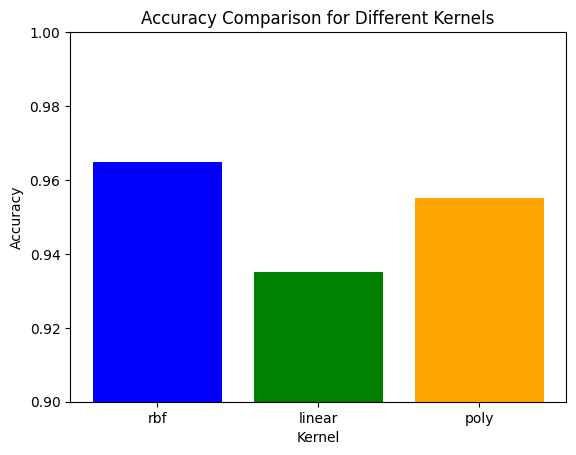

In [102]:
# Create and fit SVC models with different kernels
kernels = ['rbf', 'linear', 'poly']
models = {}

for kernel in kernels:
    svm_model = make_pipeline(SVC(kernel=kernel,probability=True))
    svm_model.fit(X_train_pca, y_train)
    y_pred = svm_model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    models[kernel] = {'model': svm_model, 'accuracy': accuracy}

# Plotting
kernels = list(models.keys())
accuracies = [info['accuracy'] for info in models.values()]

plt.bar(kernels, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison for Different Kernels')
plt.ylim(0.9, 1)  # Set y-axis limits to focus on the range from 0.9 to 1
plt.show()

In [121]:
svm_model = make_pipeline(SVC(kernel='rbf', probability=True))
svm_model.fit(X_train_pca, y_train)

y_pred = svm_model.predict(X_test_pca)

svm_accuracy = accuracy_score(y_test, y_pred)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", svm_accuracy)

Classification Report:
               precision    recall  f1-score   support

      female       0.95      0.89      0.92       331
        male       0.97      0.99      0.98      1180

    accuracy                           0.96      1511
   macro avg       0.96      0.94      0.95      1511
weighted avg       0.96      0.96      0.96      1511

Accuracy: 0.9649238914626076


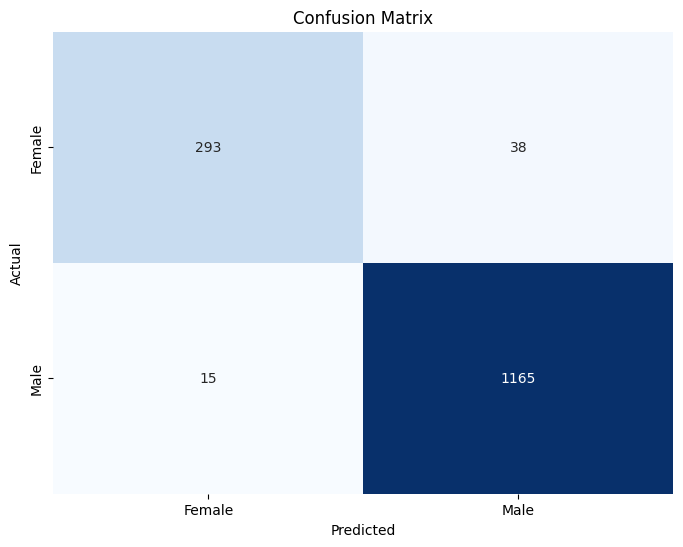

Classification Report:
               precision    recall  f1-score   support

      female       0.95      0.89      0.92       331
        male       0.97      0.99      0.98      1180

    accuracy                           0.96      1511
   macro avg       0.96      0.94      0.95      1511
weighted avg       0.96      0.96      0.96      1511

Accuracy: 0.9649238914626076


In [104]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report and accuracy
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

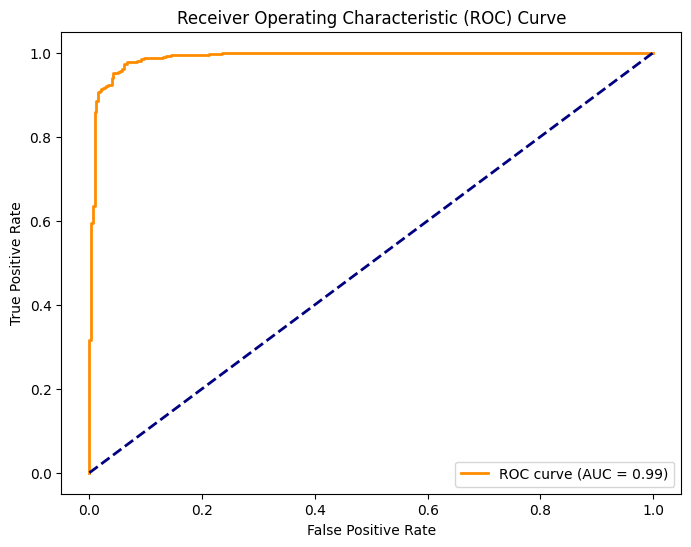

In [105]:
# Get predicted probabilities for the positive class
y_prob = svm_model.predict_proba(X_test_pca)[:, 1]

# Convert labels to binary form
label_binarizer = LabelBinarizer()
y_test_binary = label_binarizer.fit_transform(y_test)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## LDA Results

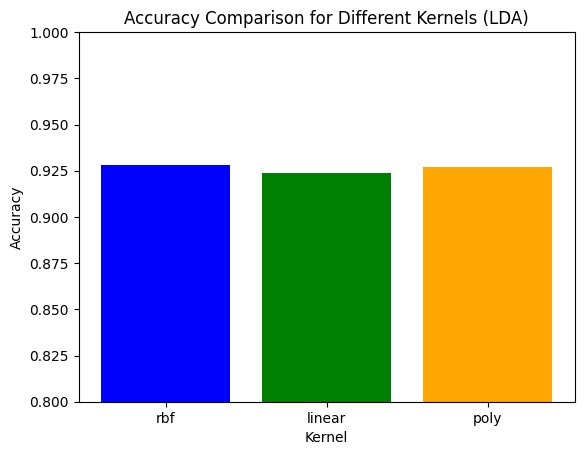

In [54]:
# Create and fit SVC models with different kernels
kernels = ['rbf', 'linear', 'poly']
models = {}

for kernel in kernels:
    svm_model = make_pipeline(SVC(kernel=kernel,probability=True))
    svm_model.fit(X_train_lda, y_train)
    y_pred = svm_model.predict(X_test_lda)
    accuracy = accuracy_score(y_test, y_pred)
    models[kernel] = {'model': svm_model, 'accuracy': accuracy}

# Plotting
kernels = list(models.keys())
accuracies = [info['accuracy'] for info in models.values()]

plt.bar(kernels, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison for Different Kernels (LDA)')
plt.ylim(0.8, 1)  # Set y-axis limits to focus on the range from 0.8 to 1
plt.show()

In [55]:
svm_model = make_pipeline(SVC(kernel='rbf', probability=True))
svm_model.fit(X_train_lda, y_train)

y_pred = svm_model.predict(X_test_lda)

svm_accuracy = accuracy_score(y_test, y_pred)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", svm_accuracy)

Classification Report:
               precision    recall  f1-score   support

      female       0.88      0.78      0.83       331
        male       0.94      0.97      0.95      1180

    accuracy                           0.93      1511
   macro avg       0.91      0.87      0.89      1511
weighted avg       0.93      0.93      0.93      1511

Accuracy: 0.927862342819325


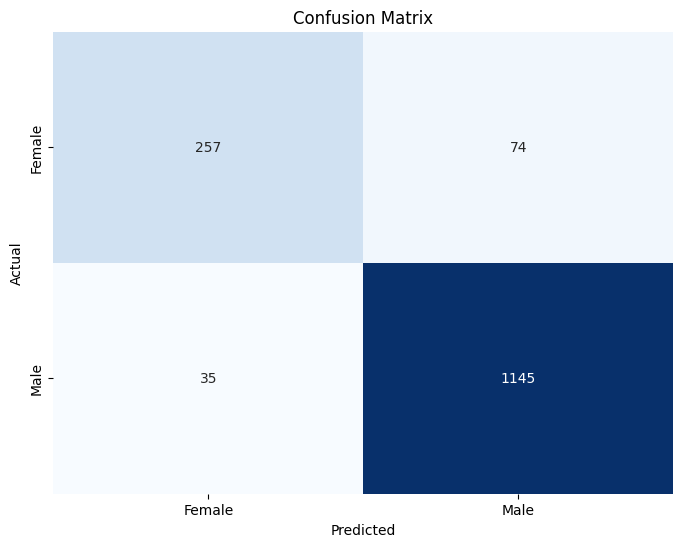

Classification Report:
               precision    recall  f1-score   support

      female       0.88      0.78      0.83       331
        male       0.94      0.97      0.95      1180

    accuracy                           0.93      1511
   macro avg       0.91      0.87      0.89      1511
weighted avg       0.93      0.93      0.93      1511

Accuracy: 0.927862342819325


In [56]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report and accuracy
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

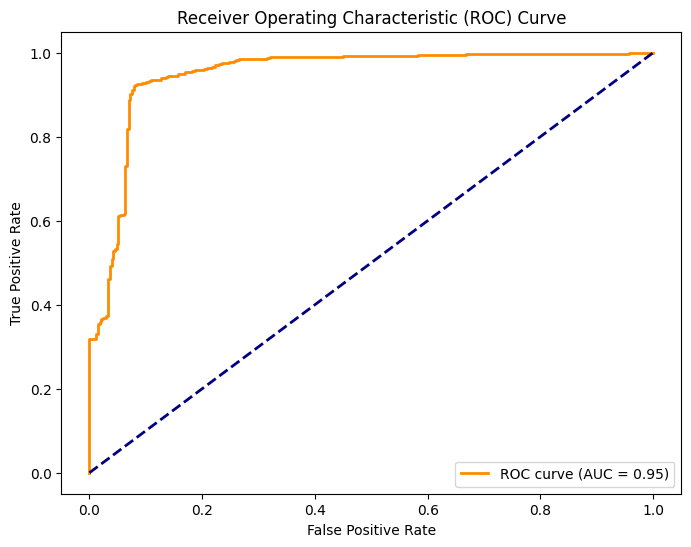

In [52]:
# Get predicted probabilities for the positive class
y_prob = svm_model.predict_proba(X_test_lda)[:, 1]

# Convert labels to binary form
label_binarizer = LabelBinarizer()
y_test_binary = label_binarizer.fit_transform(y_test)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Random Forest

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [118]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", rf_accuracy)

Classification Report:
               precision    recall  f1-score   support

      female       0.97      0.85      0.90       331
        male       0.96      0.99      0.98      1180

    accuracy                           0.96      1511
   macro avg       0.96      0.92      0.94      1511
weighted avg       0.96      0.96      0.96      1511

Accuracy: 0.9609530112508272


In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

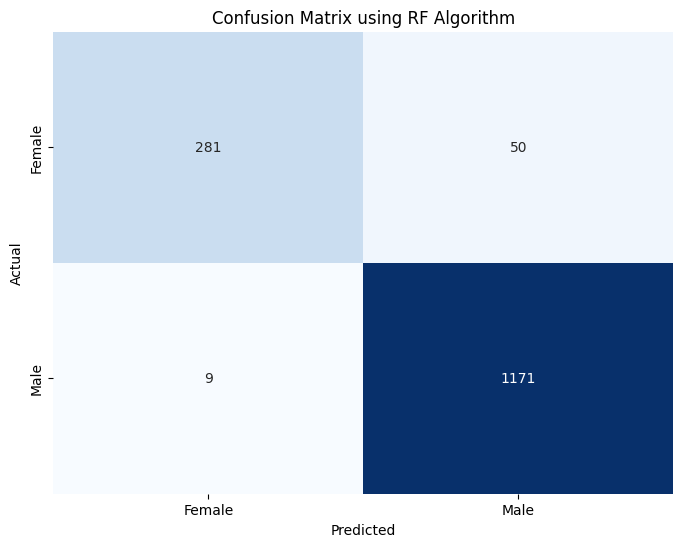

Classification Report:
               precision    recall  f1-score   support

      female       0.97      0.85      0.90       331
        male       0.96      0.99      0.98      1180

    accuracy                           0.96      1511
   macro avg       0.96      0.92      0.94      1511
weighted avg       0.96      0.96      0.96      1511

Accuracy: 0.9609530112508272


In [109]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.title('Confusion Matrix using RF Algorithm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report and accuracy
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

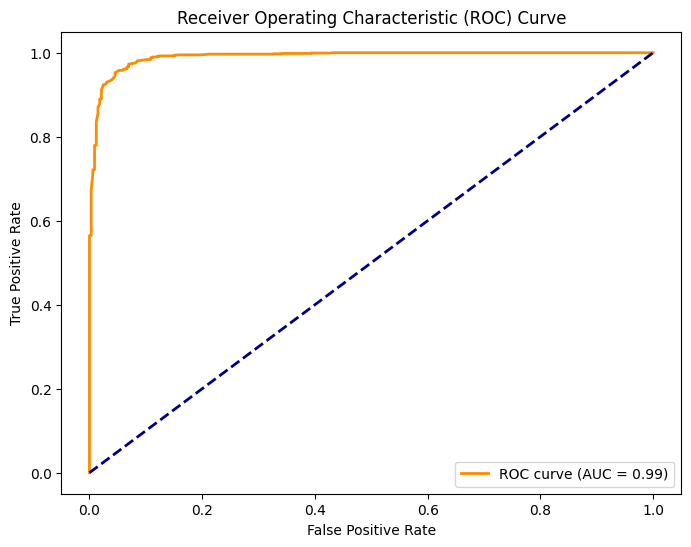

In [112]:
# Get predicted probabilities for the positive class
y_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Convert labels to binary form
label_binarizer = LabelBinarizer()
y_test_binary = label_binarizer.fit_transform(y_test)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Logistic regression

In [113]:
from sklearn.linear_model import LogisticRegression

In [114]:
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.fit_transform(X_test)

In [115]:
# Create a Logistic Regression model
logreg_model = LogisticRegression(random_state=42)

# Train the model on the training data
logreg_model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred_logreg = logreg_model.predict(X_test_scaled)

# Evaluate the model
print("Classification Report for logistic regression:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))

Classification Report for logistic regression:
               precision    recall  f1-score   support

      female       0.97      0.85      0.90       331
        male       0.96      0.99      0.98      1180

    accuracy                           0.96      1511
   macro avg       0.96      0.92      0.94      1511
weighted avg       0.96      0.96      0.96      1511

Accuracy: 0.9351422898742554


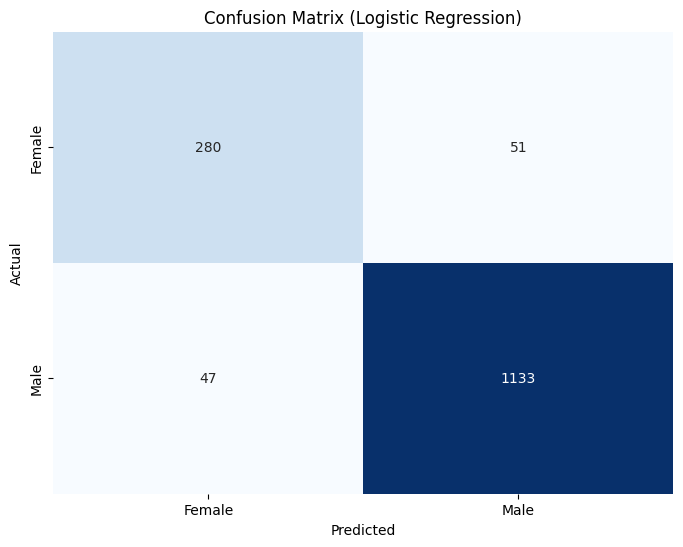

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

      female       0.86      0.85      0.85       331
        male       0.96      0.96      0.96      1180

    accuracy                           0.94      1511
   macro avg       0.91      0.90      0.90      1511
weighted avg       0.93      0.94      0.94      1511

Accuracy (Logistic Regression): 0.9351422898742554


In [119]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

log_reg_accuracy = accuracy_score(y_test, y_pred_logreg)
print("Classification Report (Logistic Regression):\n", classification_report(y_test, y_pred_logreg))
print("Accuracy (Logistic Regression):", log_reg_accuracy)

# Compare 3 algoritms

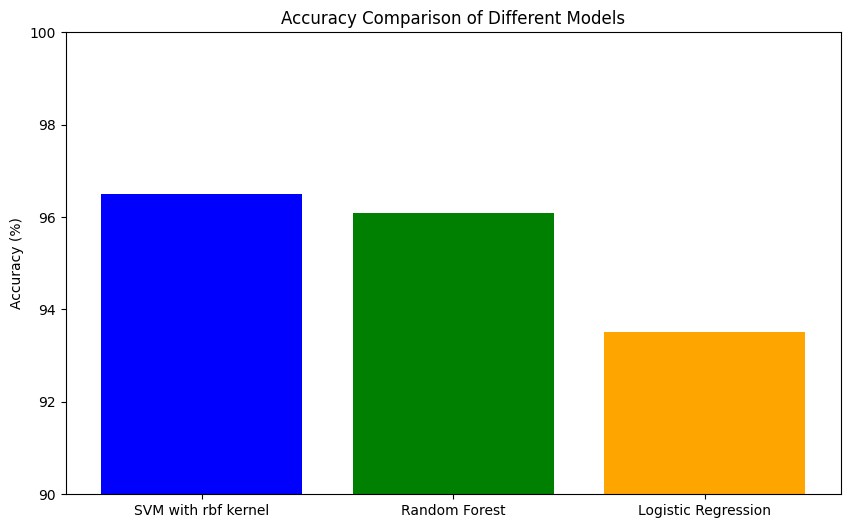

In [126]:
svm_accuracy = svm_accuracy*100
random_forest_accuracy = rf_accuracy*100
logistic_regression_accuracy = log_reg_accuracy*100

# Titles and corresponding values
titles = ["SVM with rbf kernel", "Random Forest", "Logistic Regression"]
values = [svm_accuracy, random_forest_accuracy, logistic_regression_accuracy]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(titles, values, color=['blue', 'green', 'orange'])
plt.ylim(90, 100)  # Set the y-axis limit to 100 for percentage values
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison of Different Models')
plt.show()